**Содержание**:
* [Создание датасета](#dataset)
    * Сбор данных
    * Подготовка для обучения модели
    * Обучение модели
    * Разметка с помощью предобученной модели
* [Задача классификации](#classification)
    * Мультиклассовая классификация
        * Локализация классов
        * Описательный анализ
        * Классические модели
        * Оптимизации классических моделей
        * Ансамблирование моделей
        * Уменьшение размерности
    * Бинарная классификация
        * Расширение мультиклассовой классификации
        * От мультиклассовой к бинарной
* [Задача локализации](#classification)
    * HOG
    * SVM
    * NMS
* [Нейросети. Глубокое обучение](#neural-networks)
    * R-CNN
    * YOLO

In [359]:
import shutil
from collections import defaultdict
from pathlib import Path
from typing import Callable, List, Tuple, Dict
from functools import reduce

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.notebook import tqdm

import utils

In [2]:
# @formatter:off
%matplotlib inline
%load_ext autoreload
%autoreload 2
# @formatter:on

In [3]:
plt.style.use('science')
sns.set_theme()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [4]:
# ---- Path

DATA_DIR = Path('data')
DATA_VIDEOS = DATA_DIR / 'videos'
DATA_IMAGES = DATA_DIR / 'images'
DATA_LABELS = DATA_DIR / 'labels'
DATA_CROP = DATA_DIR / 'crop'
DATA_OTHER = DATA_DIR / 'other'
DATA_PROBLEMS = DATA_OTHER / 'problems.txt'

DIST_DIR = Path('dist')
DIST_LABELS = DIST_DIR / 'labels'
DIST_LABELS_HAND = DIST_LABELS / 'hand'
DIST_LABELS_YOLO = DIST_LABELS / 'yolo'
DIST_MODELS = DIST_DIR / 'models'
DIST_PLOTS = DIST_DIR / 'plots'

# ---- Image

IMG_SIZE_ORIG = 720
IMG_SIZE_YOLO = 416

DATA_IMAGES_ORIG = DATA_IMAGES / str(IMG_SIZE_ORIG)
DATA_IMAGES_YOLO = DATA_IMAGES / str(IMG_SIZE_YOLO)

# ---- Domain

MOBS = ['zombie', 'skeleton', 'spider', 'creeper', 'enderman', 'slime']
BIOMES = [
    'plains_0', 'plains_1',
    'savanna_0', 'savanna_1',
    'desert_0', 'desert_1',
    'snowy_0', 'snowy_1',
    'cave',
]

# ---- Utils

RANDOM = np.random.default_rng(0)
COLOR_PALETTE = utils.ColorPalette([
    (8, 247, 254),
    (254, 83, 187),
    (238, 66, 102),
    (255, 210, 63),
    (59, 206, 172),
    (14, 173, 105),
], MOBS)

FIG_WIDTH_S = 6
FIG_WIDTH_M = 8
FIG_WIDTH_L = 10
FIG_WIDTH_XL = 12
FIG_WIDTH_XXL = 14

# ---- Mosaic

MOSAIC_3 = utils.Mosaic("""
    AAB
    AAC
""")

MOSAIC_15 = utils.Mosaic("""
    ABEEFF
    CDEEFF
    GGGGHH
    GGGGHH
    GGGGKL
    GGGGMN
    OOPPQQ
    OOPPQQ
""")

MOSAIC_27 = utils.Mosaic("""
    AABBCDEFGH
    AABBIIIIII
    JJJJIIIIII
    JJJJIIIIII
    JJJJIIIIII
    JJJJIIIIII
    KKLMIIIIII
    KKNOPPPQQR
    XYWWPPPQQS
    Z0WWPPPTUV
""")

# Создание датасета <a name="dataset"></a>

## Сбор данных <a name="dataset-collection"></a>

In [11]:
def video2frames(path: Path, save_dir: Path, name: str):
    vidcap = cv2.VideoCapture(str(path))
    ok, img = vidcap.read()
    cnt = 0
    while ok:
        cv2.imwrite(str(save_dir / f'{name}_{cnt:02}.jpg'), img[:, 75:img.shape[0] + 75])
        cnt += 1
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (cnt * 500))
        ok, img = vidcap.read()


def create_images_from_videos(video_path: Path, image_path: Path):
    """Создает картинки для всех групп мобов из соответствующих видео"""
    for i, mob in enumerate(tqdm(MOBS)):
        mob_ = f'{i:02}_{mob}'
        for j, biome in enumerate(tqdm(BIOMES)):
            biome_ = f'{j:02}_{biome}'
            video2frames(video_path / mob_ / f'{biome_}.mkv', image_path, f'{mob_}_{biome_}')


In [21]:
create_images_from_videos(DATA_VIDEOS, DATA_IMAGES_ORIG)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

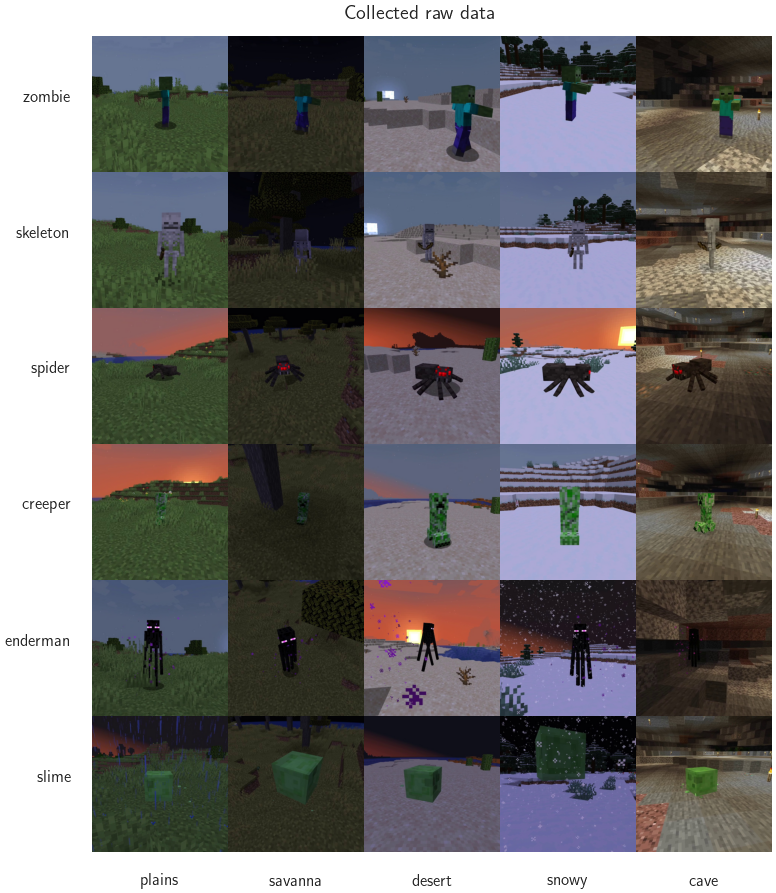

In [68]:
biomes_sample = [
    '00_plains_0_01.jpg',
    '03_savanna_1_25.jpg',
    '04_desert_0_12.jpg',
    '06_snowy_0_01.jpg',
    '08_cave_08.jpg'
]
biomes_sample_names = [i.split('_')[1] for i in biomes_sample]
images_sample = []
for i, mob in enumerate(MOBS):
    mob_ = f'{i:02}_{mob}'
    for biome in biomes_sample:
        path = DATA_IMAGES_ORIG / f'{mob_}_{biome}'
        images_sample.append(utils.Image.open(path).data)

nrows, ncols = 6, 5
fig: Figure = plt.figure(figsize=(utils.rectsize(9, nrows, ncols)))
fig.suptitle('Collected raw data', y=0.91)

grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0)
for i, (ax, img) in enumerate(zip(grid, images_sample)):
    utils.reset_axes(ax)

    row = i // ncols
    col = i % ncols
    if col == 0:
        ax.set_ylabel(MOBS[row], rotation=0, labelpad=8, horizontalalignment='right', size=12)
    if row == nrows - 1:
        ax.set_xlabel(biomes_sample_names[col], labelpad=8, size=12)

    ax.imshow(img)

utils.savefig(DIST_PLOTS / 'mobs_biomes.png', fig)
del images_sample

## Подготовка для обучения модели

In [62]:
def resize_images(orig_dir: Path, resize_dir: Path, size: int):
    for img_path in tqdm(list(orig_dir.iterdir())):
        img = utils.Image.open(img_path)
        img.data = cv2.resize(img.data, (size, size))
        img.save(resize_dir / img_path.name)


def sample_for_labeling(images_dir: Path, labels_dir: Path, use_fixed: bool = False):
    """Выбирает случайный набор изображений для создания ручной разметки"""

    target_dir = labels_dir / 'images'
    shutil.rmtree(target_dir, ignore_errors=True)
    target_dir.mkdir()

    if use_fixed:
        fixed_dir = labels_dir / '.fixed'
        for f in (fixed_dir / 'images').iterdir():
            shutil.copy(f, target_dir)

        _labels = labels_dir / 'labels'
        shutil.rmtree(_labels, ignore_errors=True)
        _labels.mkdir()
        for f in (fixed_dir / 'labels').iterdir():
            shutil.copy(f, _labels)

    else:
        images = defaultdict(list)
        for f in images_dir.iterdir():
            mob = f.name.split('_')[1]
            images[mob].append(f)

        for files in images.values():
            for f in np.sort(RANDOM.choice(files, size=40, replace=False)):
                shutil.copy(f, target_dir)


def create_dataset_for_yolo(labels_dir: Path, dataset_dir: Path):
    """Создает датасет из размеченных данных для обучения YOLOv5"""

    def train_augment(
            img: np.ndarray,
            cls: int,
            bbox: utils.BBox
    ) -> List[Tuple[np.ndarray, int, utils.BBox, str]]:
        orig = (img, cls, bbox)
        orig_pos_rotated = utils.transform(utils.a_rotate(10), *orig)
        orig_neg_rotated = utils.transform(utils.a_rotate(-10), *orig)
        orig_pos_pos_shear = utils.transform(utils.a_shear(12, 12), *orig)
        orig_neg_pos_shear = utils.transform(utils.a_shear(-12, 12), *orig)
        orig_pos_neg_shear = utils.transform(utils.a_shear(12, -12), *orig)
        orig_neg_neg_shear = utils.transform(utils.a_shear(-12, -12), *orig)

        flipped = utils.transform(utils.a_horizontal_flip(), *orig)
        flipped_pos_rotated = utils.transform(utils.a_rotate(10), *flipped)
        flipped_neg_rotated = utils.transform(utils.a_rotate(-10), *flipped)
        flipped_pos_pos_shear = utils.transform(utils.a_shear(12, 12), *flipped)
        flipped_neg_pos_shear = utils.transform(utils.a_shear(-12, 12), *flipped)
        flipped_pos_neg_shear = utils.transform(utils.a_shear(12, -12), *flipped)
        flipped_neg_neg_shear = utils.transform(utils.a_shear(-12, -12), *flipped)

        return [
            (*orig, ''),
            (*orig_pos_rotated, 'pos_rotated'),
            (*orig_neg_rotated, 'neg_rotated'),
            (*orig_pos_pos_shear, 'pos_pos_shear'),
            (*orig_neg_pos_shear, 'neg_pos_shear'),
            (*orig_pos_neg_shear, 'pos_neg_shear'),
            (*orig_neg_neg_shear, 'neg_neg_shear'),

            (*flipped, 'flip'),
            (*flipped_pos_rotated, 'flip_pos_rotated'),
            (*flipped_neg_rotated, 'flip_neg_rotated'),
            (*flipped_pos_pos_shear, 'pos_pos_shear'),
            (*flipped_neg_pos_shear, 'neg_pos_shear'),
            (*flipped_pos_neg_shear, 'pos_neg_shear'),
            (*flipped_neg_neg_shear, 'neg_neg_shear'),
        ]

    def test_augment(
            img: np.ndarray,
            cls: int,
            bbox: utils.BBox
    ) -> List[Tuple[np.ndarray, int, utils.BBox, str]]:
        orig = (img, cls, bbox)
        flipped = utils.transform(utils.a_horizontal_flip(), *orig)
        return [(*orig, ''), (*flipped, 'flip')]  # type: ignore

    def save_augment(
            augment: Callable[[np.ndarray, int, utils.BBox], List[Tuple[np.ndarray, int, utils.BBox, str]]],
            images: List[Path],
            labels: List[Path],
            name: str
    ):
        images_dir = dataset_dir / name / 'images'
        images_dir.mkdir(exist_ok=True, parents=True)
        labels_dir = dataset_dir / name / 'labels'
        labels_dir.mkdir(exist_ok=True, parents=True)
        for img_path, label_path in zip(images, labels):
            img = utils.Image.open(img_path)
            label = utils.Label.open(label_path)
            augments = augment(img.data, label.cls, label.bbox)
            for data, cls, bbox, name in augments:
                utils.Image(data).save(images_dir / f'{"_".join([img_path.stem, name])}.jpg')
                utils.Label(cls, bbox).save(labels_dir / f'{"_".join([label_path.stem, name])}.txt')

    by_mobs = defaultdict(list)
    for img, label in zip((labels_dir / 'images').iterdir(), (labels_dir / 'labels').iterdir()):
        mob = img.name.split('_')[1]
        by_mobs[mob].append((img, label))

    for mob, images_labels in tqdm(by_mobs.items()):
        images, labels = zip(*images_labels)
        images_train, images_valid, images_test, labels_train, labels_valid, labels_test = utils.train_valid_test_split(
            images,
            labels,
            train_size=0.8,
            valid_size=0.1,
            random_state=0,
        )

        save_augment(train_augment, images_train, labels_train, 'train')
        save_augment(test_augment, images_valid, labels_valid, 'valid')
        save_augment(test_augment, images_test, labels_test, 'test')

    colab_root = Path('/content')
    train_data_path = str((colab_root / dataset_dir / 'train/images').as_posix())
    valid_data_path = str((colab_root / dataset_dir / 'valid/images').as_posix())
    test_data_path = str((colab_root / dataset_dir / 'test/images').as_posix())

    data = {
        'names': MOBS,
        'nc': len(MOBS),
        'train': train_data_path,
        'val': valid_data_path,
        'test': test_data_path,
    }
    utils.write_yaml(dataset_dir / 'data.yaml', data)

    only_train_path = [train_data_path, valid_data_path, test_data_path]
    only_train_data = {
        'names': MOBS,
        'nc': len(MOBS),
        'train': only_train_path,
        'val': only_train_path,
    }
    utils.write_yaml(dataset_dir / 'only_train_data.yaml', only_train_data)


In [38]:
resize_images(DATA_IMAGES_ORIG, DATA_IMAGES_YOLO, size=IMG_SIZE_YOLO)

  0%|          | 0/3787 [00:00<?, ?it/s]

In [64]:
sample_for_labeling(DATA_IMAGES_YOLO, DIST_LABELS_HAND, use_fixed=True)

In [65]:
# @formatter:off
%%capture

!.\venv39\Scripts\activate
!labelImg dist\labels\hand\images dist\labels\hand\labels\classes.txt dist\labels\hand\labels
!.\venv38\Scripts\activate
# @formatter:on

In [66]:
create_dataset_for_yolo(DIST_LABELS_HAND, DIST_LABELS_YOLO)

  0%|          | 0/6 [00:00<?, ?it/s]

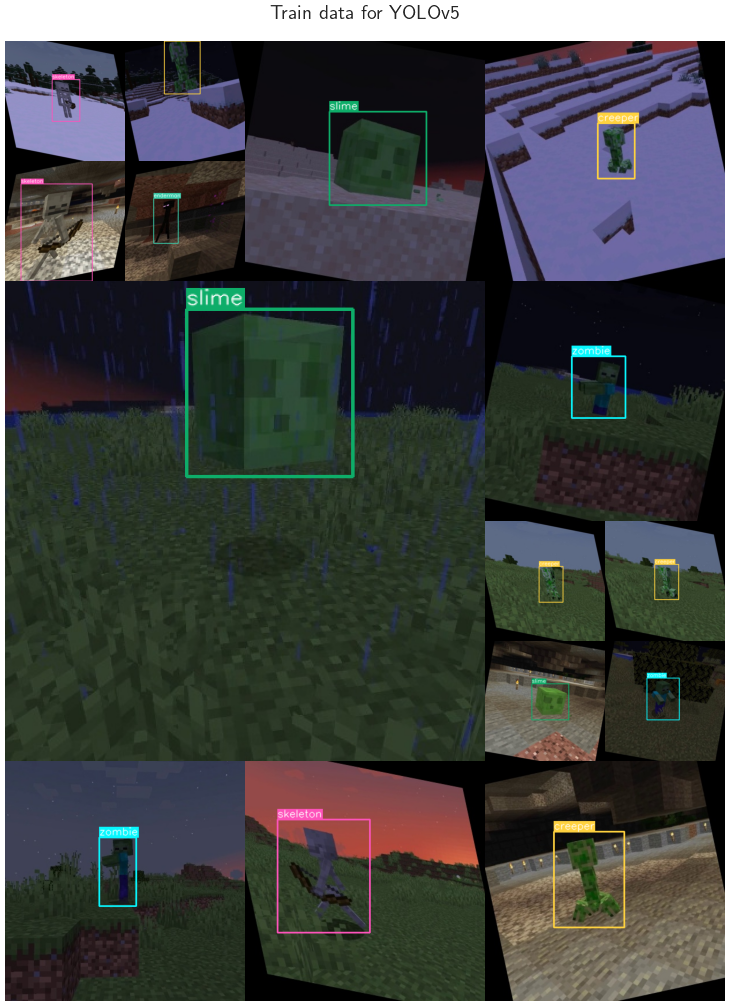

In [84]:
yolo_images_sample = sorted((DIST_LABELS_YOLO / 'train' / 'images').iterdir())
yolo_labels_sample = sorted((DIST_LABELS_YOLO / 'train' / 'labels').iterdir())
yolo_mobs_sample = [f.name.split('_')[1] for f in yolo_images_sample]

yolo_sample = RANDOM.choice(
    list(zip(yolo_images_sample, yolo_labels_sample, yolo_mobs_sample)),
    size=MOSAIC_15.nimages,
    replace=False
)

yolo_sample_plot = []
for i, (img_path, label_path, mob) in enumerate(yolo_sample):
    img = utils.Image.open(img_path)
    label = utils.Label.open(label_path)
    yolo_sample_plot.append(utils.visualize_bbox(img.data, label.bbox, mob, color=COLOR_PALETTE.get(mob)))

fig = MOSAIC_15.plot(yolo_sample_plot, fig_width=9, title='Train data for YOLOv5', title_kw={'y': 0.93})

utils.savefig(DIST_PLOTS / 'yolo_train_data_mosaic.png', fig)
del yolo_sample_plot

## Обучение модели в Google Colab

In [12]:
# 01_colab.ipynb - код для запуска в colab

## Разметка с помощью предобученной модели

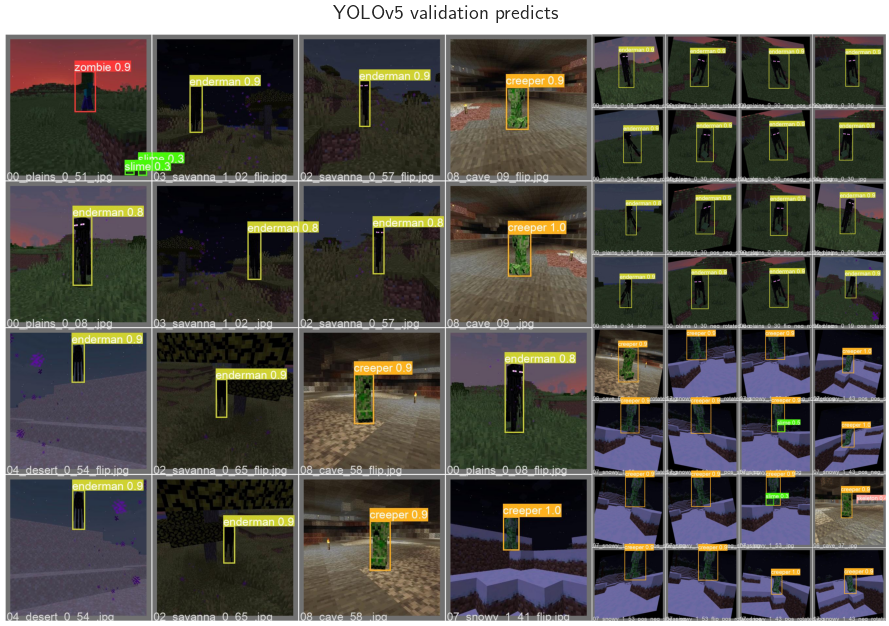

In [90]:
predict_batches = list((DIST_MODELS / 'yolov5/labeler/runs/train/exp').glob('val_batch?_pred.jpg'))
predict_plot = [utils.Image.open(i).data for i in predict_batches]

fig = MOSAIC_3.plot(predict_plot, fig_width=11, title='YOLOv5 validation predicts', title_kw={'y': 0.94})

utils.savefig(DIST_PLOTS / 'yolo_val_predicts_mosaic.png', fig)
del predict_plot

In [13]:
import yolov5
from yolov5.models.common import Detections, AutoShape

In [14]:
def yolo_labeling(yolo: AutoShape, images_dir: Path, labels_dir: Path) -> List[str]:
    problems = []

    batch = 200
    images = list(images_dir.iterdir())
    for i in tqdm(range(0, len(images) + 1, batch)):
        detects: Detections = yolo(images[i:i + batch], size=IMG_SIZE_YOLO)
        for detection, fname in zip(detects.xywhn, detects.files):
            mob_idx = MOBS.index(fname.split('_')[1])
            detection = detection[detection[:, -1] == mob_idx]
            if len(detection):
                detection = detection[detection[:, -2].argsort(descending=True)]
                *bbox, _, cls = detection[0]
                label = utils.Label(int(cls), utils.BBox(*map(float, bbox)))
                label.save(labels_dir / Path(fname).with_suffix('.txt'))
            else:
                problems.append(fname)
                with open(labels_dir / Path(fname).with_suffix('.txt'), 'w'):
                    pass

    with open(labels_dir / 'classes.txt', 'w') as f:
        f.write('\n'.join(MOBS))

    return problems


In [15]:
yolo = yolov5.load(DIST_MODELS / 'yolov5/labeler/runs/train/exp/weights/best.pt')

In [16]:
problems = yolo_labeling(yolo, DATA_IMAGES_YOLO, DATA_LABELS)
utils.write_problems(DATA_PROBLEMS, problems)
problems

  0%|          | 0/19 [00:00<?, ?it/s]

['00_zombie_03_savanna_1_12.jpg',
 '02_spider_01_plains_1_00.jpg',
 '02_spider_01_plains_1_04.jpg',
 '02_spider_01_plains_1_05.jpg',
 '02_spider_01_plains_1_53.jpg',
 '02_spider_01_plains_1_63.jpg',
 '02_spider_02_savanna_0_44.jpg',
 '02_spider_02_savanna_0_69.jpg',
 '02_spider_02_savanna_0_70.jpg',
 '02_spider_06_snowy_0_28.jpg',
 '02_spider_07_snowy_1_63.jpg',
 '02_spider_07_snowy_1_64.jpg',
 '03_creeper_02_savanna_0_69.jpg',
 '04_enderman_02_savanna_0_68.jpg',
 '04_enderman_05_desert_1_18.jpg']

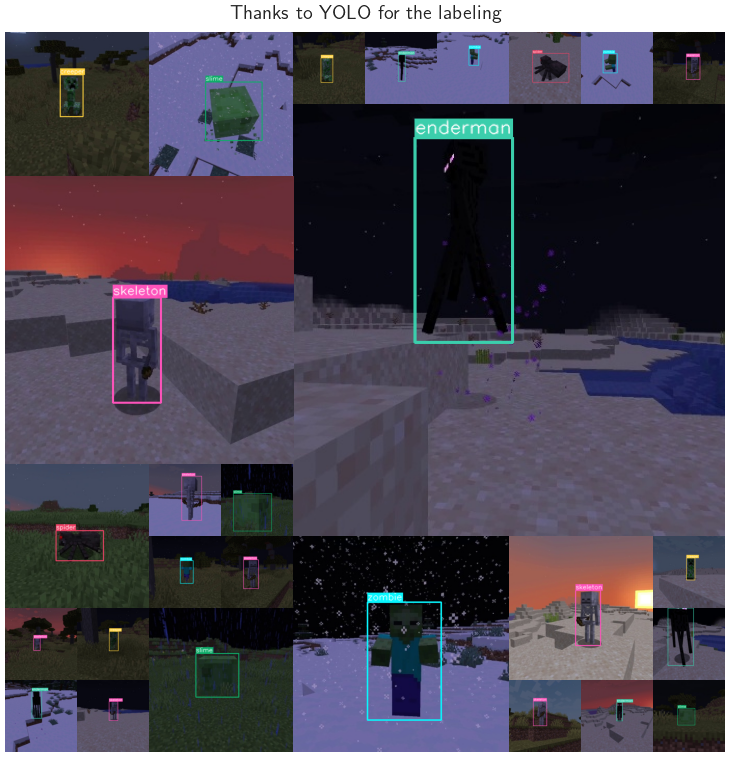

In [95]:
images_sample = sorted(DATA_IMAGES_YOLO.iterdir())
labels_sample = sorted(DATA_LABELS.iterdir())
mobs_sample = [f.name.split('_')[1] for f in images_sample]

sample = RANDOM.choice(
    list(zip(images_sample, labels_sample, mobs_sample)),
    size=MOSAIC_27.nimages,
    replace=False
)

sample_plot = []
for i, (img_path, label_path, mob) in enumerate(sample):
    img = utils.Image.open(img_path)
    label = utils.Label.open(label_path)
    sample_plot.append(utils.visualize_bbox(img.data, label.bbox, mob, color=COLOR_PALETTE.get(mob)))

fig = MOSAIC_27.plot(sample_plot, fig_width=9, title='Thanks to YOLO for the labeling', title_kw={'y': 0.93})

utils.savefig(DIST_PLOTS / 'yolo_labeling_mosaic.png', fig)
del sample_plot

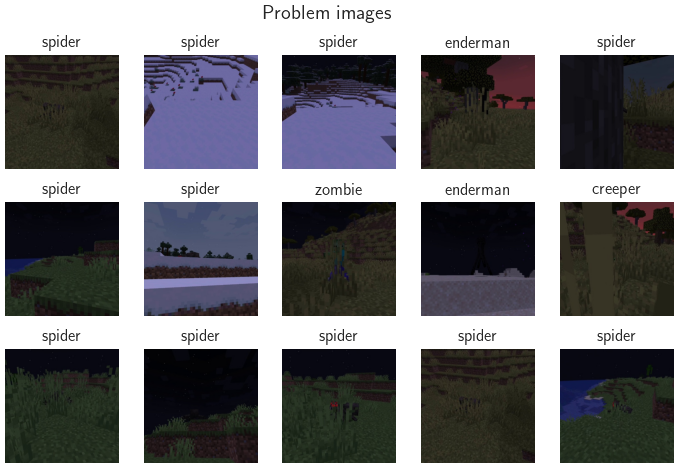

In [49]:
problem_images = [
    utils.Image.open(DATA_IMAGES_YOLO / p).data
    for p in problems
]

nrows, ncols = 3, 5
fig: Figure = plt.figure(figsize=(utils.rectsize(9, nrows, ncols)))
fig.suptitle('Problem images', y=0.975)

grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=(1 / 4, 1 / 3))
for i, (ax, img) in enumerate(zip(grid, problem_images)):
    utils.reset_axes(ax)
    ax.set_title(problems[i][:-4].split('_')[1])
    ax.imshow(img)

utils.savefig(DIST_PLOTS / 'yolo_problem_images.png', fig)
del problem_images

# Задача классификации <a name="classification"></a>

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
import pandas as pd
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.semi_supervised import SelfTrainingClassifier
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.ensemble import StackingClassifier, VotingClassifier
# from sklearn.multiclass import OutputCodeClassifier, OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [180]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier,
    RidgeClassifier,
    PassiveAggressiveClassifier
)
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

In [29]:
problems = set(utils.load_problems(DATA_PROBLEMS))
TIDY_IMAGE_NAMES = [f.stem for f in DATA_IMAGES_ORIG.iterdir() if f.name not in problems]
len(TIDY_IMAGE_NAMES)

3772

## Мультиклассовая классификация

### Локализация классов

In [30]:
min_max_bbox_labels = []
for name in TIDY_IMAGE_NAMES:
    label = utils.Label.open((DATA_LABELS / name).with_suffix('.txt'))
    *_, w, h = label.bbox.xywhn
    a = max(w, h)
    min_max_bbox_labels.append((a, label))

min_max_bbox_labels = sorted(min_max_bbox_labels, key=lambda x: x[0])

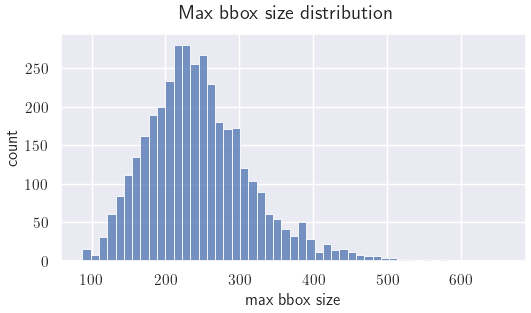

In [33]:
fig, ax = plt.subplots(figsize=(6, 3))
ax = sns.histplot(x=np.array([i[0] for i in min_max_bbox_labels]) * IMG_SIZE_ORIG, ax=ax)
fig.suptitle('Max bbox size distribution')
ax.set_xlabel('max bbox size')
ax.set_ylabel('count')

utils.savefig(DIST_PLOTS / 'max_bbox_size_distribution.png', fig)

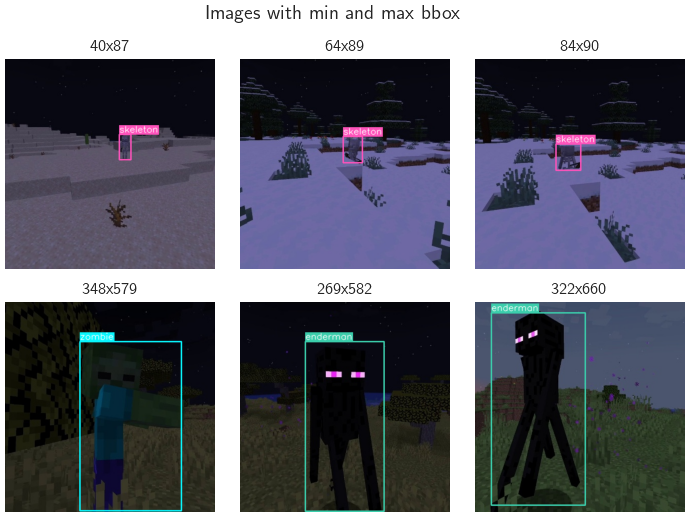

In [32]:
min_max_bbox_labels_sample = [*min_max_bbox_labels[:3], *min_max_bbox_labels[-3:]]

sample_plot = []
for _, label in min_max_bbox_labels_sample:
    name = label.path.name
    mob = name.split('_')[1]
    img = utils.Image.open((DATA_IMAGES_YOLO / name).with_suffix('.jpg'))

    *_, w, h = label.bbox.xywhn
    sample_plot.append((
        f'{int(w * IMG_SIZE_ORIG)}x{int(h * IMG_SIZE_ORIG)}',
        utils.visualize_bbox(img.data, label.bbox, mob, color=COLOR_PALETTE.get(mob)),
    ))

nrows, ncols = 2, 3
fig: Figure = plt.figure(figsize=(utils.rectsize(9, nrows, ncols)))
fig.suptitle('Images with min and max bbox', y=0.97)

grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=(1 / 4, 1 / 3))
for i, (ax, (title, img)) in enumerate(zip(grid, sample_plot)):
    utils.reset_axes(ax)
    ax.set_title(title)
    ax.imshow(img)

utils.savefig(DIST_PLOTS / 'min_max_bboxes.png', fig)
del sample_plot

In [35]:
TARGET_SIZE = 64

In [36]:
# https://blog.roboflow.com/you-might-be-resizing-your-images-incorrectly/#how-should-i-fill-padding-pixels
# https://forums.fast.ai/t/partial-convergence-padding-vs-reflection-zero-etc/43508

In [37]:
dataset = {'images': [], 'target': []}

for name in tqdm(TIDY_IMAGE_NAMES):
    img = utils.Image.open((DATA_IMAGES_ORIG / name).with_suffix('.jpg'))
    label = utils.Label.open((DATA_LABELS / name).with_suffix('.txt'))
    new_img = cv2.resize(utils.crop_bbox_rect(img.data, label.bbox, pad=2), (TARGET_SIZE, TARGET_SIZE))
    dataset['images'].append(new_img)
    dataset['target'].append(label.cls)

dataset['images'] = np.array(dataset['images'], dtype='uint8')
dataset['data'] = dataset['images'].reshape(dataset['images'].shape[0], -1)
dataset['target'] = np.array(dataset['target'], dtype='uint8')

  0%|          | 0/3772 [00:00<?, ?it/s]

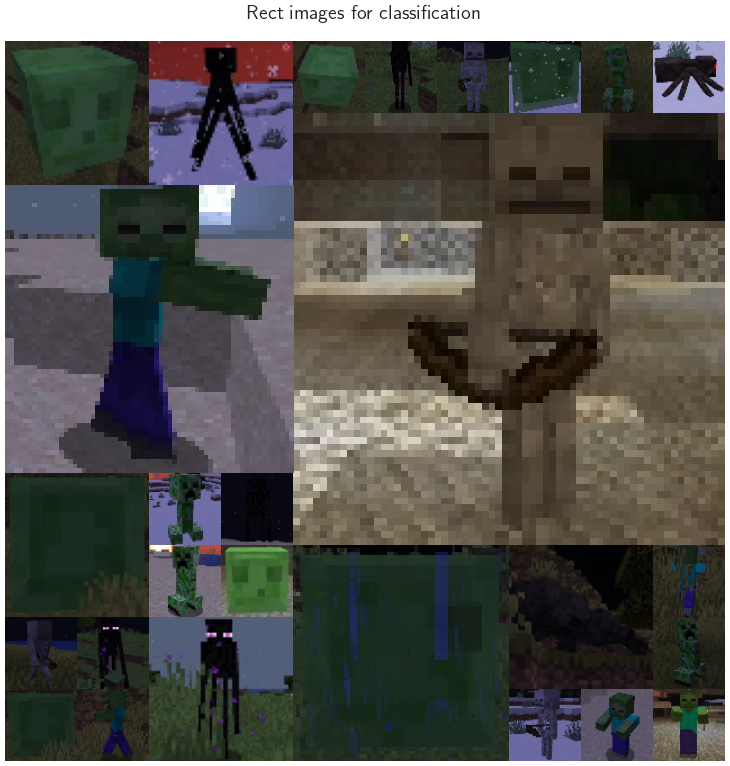

In [40]:
fig = MOSAIC_27.plot(
    RANDOM.choice(dataset['images'], size=MOSAIC_27.nimages, replace=False),
    fig_width=9,
    title='Rect images for classification',
    title_kw={'y': 0.94}
)

utils.savefig(DIST_PLOTS / 'rect_class_images_mosaic.png', fig)

### Описательный анализ

In [41]:
print(
    f'Classes: {len(np.unique(dataset["target"]))}\n'
    f'Samples total: {len(dataset["target"])}\n'
    f'Features: {dataset["data"].shape[1]} (int, {dataset["data"].min()}..{dataset["data"].max()})\n'
    f'Image size: {" x ".join(map(str, dataset["images"][0].shape))}'
)

Classes: 6
Samples total: 3772
Features: 12288 (int, 0..255)
Image size: 64 x 64 x 3


In [42]:
X = dataset['images']
y = dataset['target']

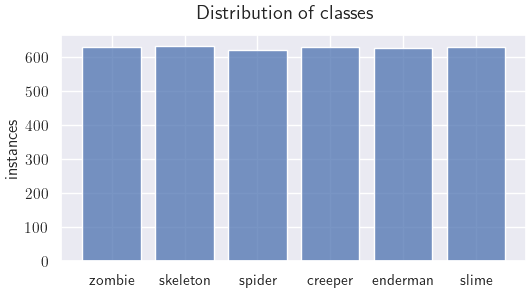

In [44]:
ax: Axes = sns.histplot(x=[MOBS[i] for i in y], shrink=0.8, hue_order=MOBS)
ax.figure.set_size_inches(6, 3)
ax.set_ylabel('instances')
ax.figure.suptitle('Distribution of classes')

utils.savefig(DIST_PLOTS / 'distribution_of_classes.png', ax.figure)

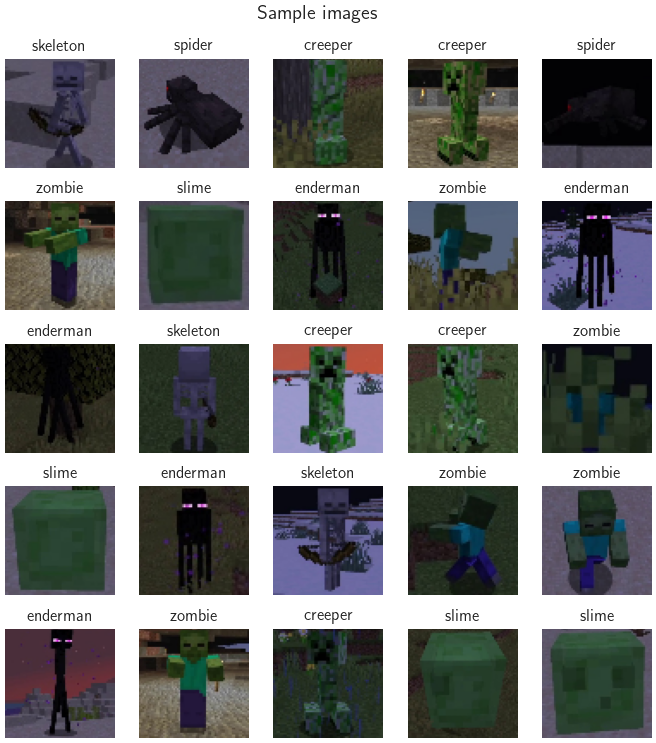

In [47]:
nrows, ncols = 5, 5
fig: Figure = plt.figure(figsize=(utils.rectsize(9, nrows, ncols)))
fig.suptitle('Sample images', y=0.94)

grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=(1 / 4, 1 / 3))
for i, (ax, j) in enumerate(zip(grid, RANDOM.integers(len(dataset['target']), size=nrows * ncols))):
    cls = dataset['target'][j]
    img = dataset['images'][j]

    utils.reset_axes(ax)
    ax.set_title(MOBS[cls])
    ax.imshow(img)

utils.savefig(DIST_PLOTS / 'classification_sample_images.png', fig)

### Классические модели

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=0)

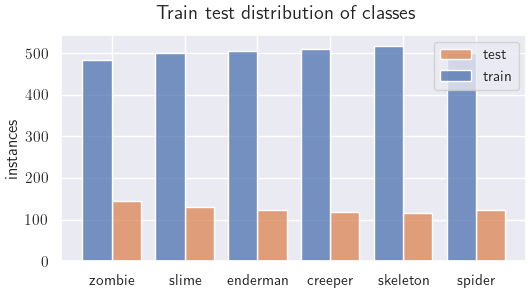

In [71]:
df_train = pd.DataFrame(y_train, columns=['cls'])
df_train['sample'] = 'train'
df_test = pd.DataFrame(y_test, columns=['cls'])
df_test['sample'] = 'test'
data = pd.concat([df_train, df_test], ignore_index=True)
data['cls'] = data['cls'].map(lambda x: MOBS[x])

ax: Axes = sns.histplot(data=data, x='cls', hue='sample', multiple='dodge', shrink=0.8)
ax.figure.set_size_inches(6, 3)
ax.figure.suptitle('Train test distribution of classes')
ax.set_xlabel('')
ax.set_ylabel('instances')
ax.legend(['test', 'train'], frameon=True)

utils.savefig(DIST_PLOTS / 'train_test_split_distribution.png', ax.figure)

In [72]:
class Flatter(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)


In [94]:
flatter = Flatter()
X_train_ = flatter.fit_transform(X_train)
X_test_ = flatter.transform(X_test)

clf = LogisticRegression(max_iter=500)

In [95]:
# @formatter:off

In [96]:
%%time

clf.fit(X_train_, y_train);

CPU times: total: 2min 40s
Wall time: 35 s


LogisticRegression(max_iter=500)

In [97]:
%%time

y_pred = clf.predict(X_test_)
# @formatter:on

CPU times: total: 15.6 ms
Wall time: 28 ms


In [98]:
print(metrics.classification_report(y_test, y_pred, digits=3, target_names=MOBS, zero_division=0))

              precision    recall  f1-score   support

      zombie      0.993     0.993     0.993       145
    skeleton      1.000     1.000     1.000       116
      spider      0.992     0.984     0.988       122
     creeper      1.000     0.983     0.992       119
    enderman      0.976     0.992     0.984       122
       slime      0.992     1.000     0.996       131

    accuracy                          0.992       755
   macro avg      0.992     0.992     0.992       755
weighted avg      0.992     0.992     0.992       755



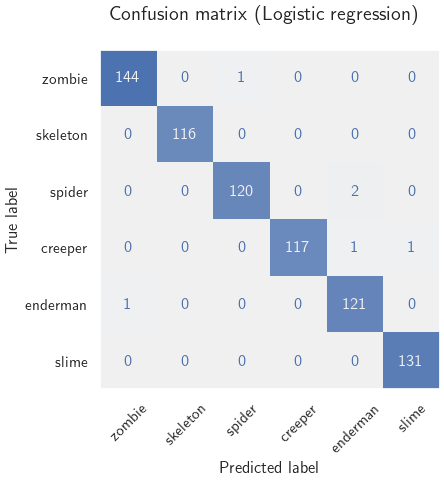

In [102]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=MOBS,
    colorbar=False,
    xticks_rotation=45,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)
cm_display.figure_.suptitle('Confusion matrix (Logistic regression)')

utils.savefig(DIST_PLOTS / 'logistic_regression_confusion_matrix.png', cm_display.figure_)

In [104]:
y_decision_f = MinMaxScaler().fit_transform(clf.decision_function(X_test_))

y_pred_proba = clf.predict_proba(X_test_)
df = pd.DataFrame(y_pred_proba)
worst_proba = df.iloc[df.max(axis=1).argsort()]

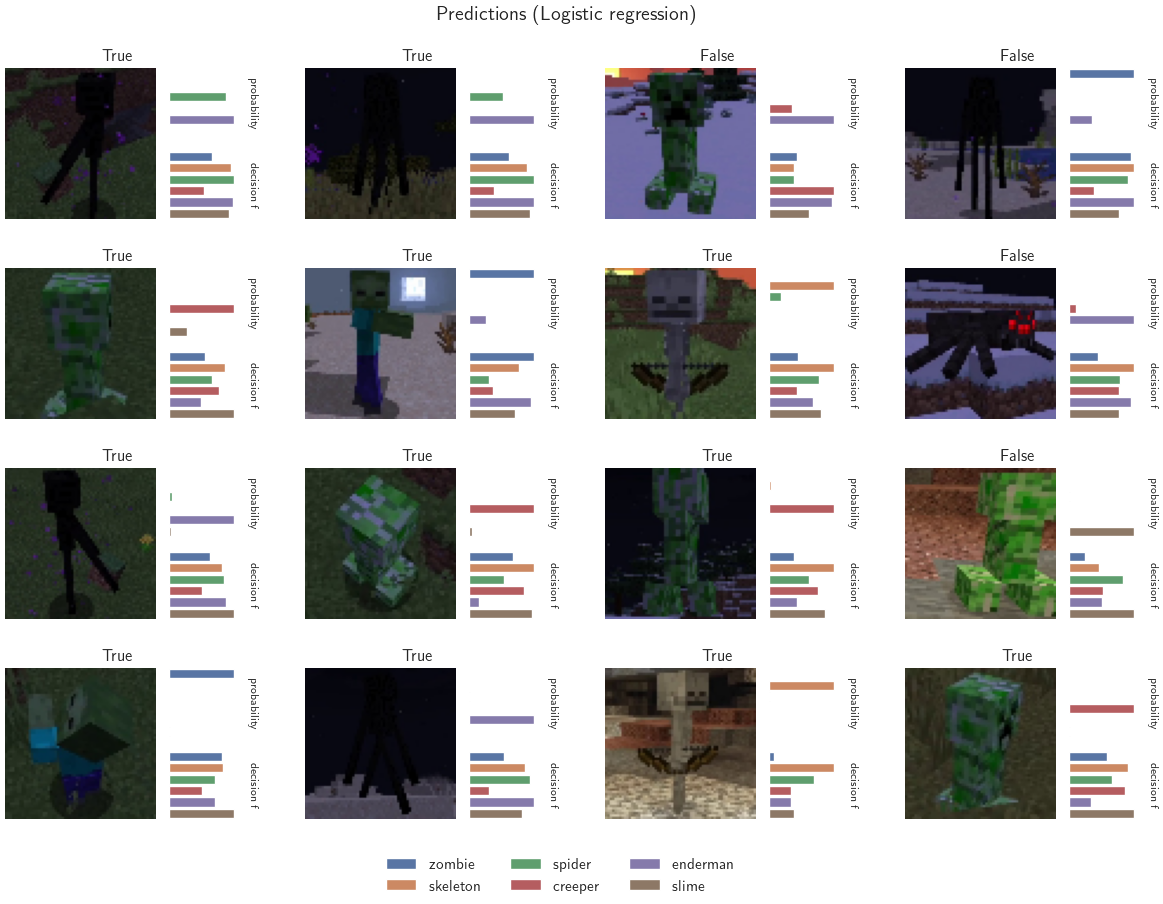

In [179]:
nrows, ncols = 4, 4
fig = utils.plot_probability_grid(
    nrows=nrows,
    ncols=ncols,
    idxs=worst_proba[:4 * 4].index,
    y_true=y_test,
    y_pred=y_pred,
    proba=y_pred_proba,
    decision_f=y_decision_f,
    images=X_test,
    labels=MOBS,
    figsize=(3 * nrows, 2 * ncols),
)
fig.suptitle('Predictions (Logistic regression)', y=1.05)

utils.savefig(DIST_PLOTS / 'logistic_regression_predict_probability.png', fig)

In [379]:
SCORING = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
_KEYS = [
    'params',
    'mean_fit_time',
    'mean_score_time',
    'mean_test_accuracy',
    'mean_test_precision_weighted',
    'mean_test_recall_weighted',
    'mean_test_f1_weighted',
]
_RENAME = {
    'params': 'pipeline',
    'mean_fit_time': 'fit time',
    'mean_score_time': 'score time',
    'mean_test_accuracy': 'accuracy',
    'mean_test_precision_weighted': 'precision (w)',
    'mean_test_recall_weighted': 'recall (w)',
    'mean_test_f1_weighted': 'f1 (w)',
}


def search_report_df(cv_results: Dict, skip: List[str] = None) -> pd.DataFrame:
    skip = skip or []

    def skip_filter(s: str) -> bool:
        for pattern in skip:
            if s.casefold().startswith(pattern.casefold()):
                return False

        return True

    def pipeline_name(p: Dict) -> str:
        s = '__'.join(filter(skip_filter, map(str, reversed(list(p.values())))))
        for i in ['random_state=0, ', 'random_state=0', '()']:
            s = s.replace(i, '')
        return s

    report = pd.DataFrame({k: cv_results[k] for k in _KEYS}).rename(columns=_RENAME).sort_values('accuracy', ascending=False)
    report['pipeline'] = report['pipeline'].apply(pipeline_name)
    return report.reset_index(drop=True)


def merge_cv_results(*cv_results: Dict) -> Dict:
    keys = reduce(lambda pred, curr: pred & curr.keys(), cv_results[1:], cv_results[0].keys())
    results = {k: [] for k in keys}
    for k in results:
        for res in cv_results:
            results[k].extend(res[k])

    return results


def search_report_plot(report: pd.DataFrame, figsize: Tuple[float, float]) -> Figure:
    ax = report.plot.bar(x='pipeline', rot=30, logy=True)
    ax.figure.set_size_inches(*figsize)

    ax.set_xlabel('')

    yticks = ax.get_yticks()
    yticks = yticks[yticks < report[report.columns[1:]].to_numpy().max()]
    # yticks = [*yticks, ax.get_yticks()[len(yticks)]]
    ax.set_yticks(yticks)
    ax.set_yticklabels(map(lambda x: f'{x:g}', yticks))

    ax.legend(frameon=True, ncol=2)
    return ax.figure

In [358]:
dct1 = {'a': 1, 'b': 1}
dct2 = {'b': 1, 'c': 2}
dct1.keys() | dct2.keys()

{'a', 'b', 'c'}

In [182]:
simple_pipline = Pipeline([
    ('flatter', Flatter()),
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(max_iter=500, random_state=0)),
])

In [183]:
classic_param_grid = [{
    'clf': [
        # LogisticRegression(max_iter=500, random_state=0),
        KNeighborsClassifier(),
        MultinomialNB(),
        DecisionTreeClassifier(random_state=0),
        ExtraTreeClassifier(random_state=0),
        # SVC(kernel='rbf'),
        # SVC(kernel='linear'),
        PassiveAggressiveClassifier(random_state=0),
    ]
}, {
    'scaler': [StandardScaler()],
    'clf': [MLPClassifier(random_state=0)],
}]

classic_search = GridSearchCV(
    simple_pipline,
    classic_param_grid,
    scoring=SCORING,
    refit='accuracy',
    cv=2,
    verbose=4,
    n_jobs=4,
)

if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        warnings.simplefilter('ignore', category=UndefinedMetricWarning)
        classic_search.fit(X_train, y_train)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


In [380]:
report_classic = search_report_df(classic_search.cv_results_, skip=['StandardScaler'])
report_classic

pipeline   fit time  score time  accuracy  \
0  PassiveAggressiveClassifier   7.123505    0.210774  0.989393   
1                MLPClassifier  16.214253    0.215234  0.987074   
2         KNeighborsClassifier   0.414623    1.940003  0.878021   
3       DecisionTreeClassifier  10.838920    0.337175  0.853834   
4          ExtraTreeClassifier   0.525874    0.207996  0.799804   
5                MultinomialNB   0.508124    0.380503  0.778252   
6                   GaussianNB   1.070499    2.151500  0.689753   

   precision (w)  recall (w)    f1 (w)  
0       0.989510    0.989393  0.989403  
1       0.987145    0.987074  0.987069  
2       0.887177    0.878021  0.874801  
3       0.854656    0.853834  0.853381  
4       0.800711    0.799804  0.799790  
5       0.796130    0.778252  0.778374  
6       0.757915    0.689753  0.694442

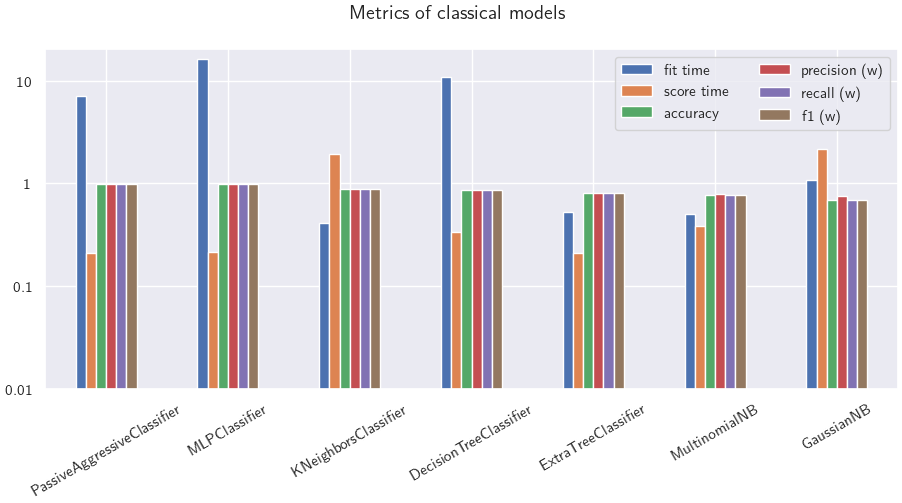

In [382]:
fig = search_report_plot(report_classic, figsize=(11, 4.5))
fig.suptitle('Metrics of classical models')

utils.savefig(DIST_PLOTS / 'metrics_report_classic_models.png', fig)

### Оптимизации классических моделей

In [164]:
optimized_param_grid = [{
    'clf': [
        RidgeClassifier(random_state=0),  # переход от классификации к регрессии
        SGDClassifier(loss='hinge', random_state=0),  # LinearSVC
        SGDClassifier(loss='log', random_state=0),  # LogisticRegression
        SGDClassifier(loss='modified_huber', random_state=0),  # толерантность к выбросам
        SGDClassifier(loss='squared_hinge', random_state=0),  # SVC с квадратичным штрафом
        SGDClassifier(loss='perceptron', random_state=0),  # MLP
    ]
}]

optimized_search = GridSearchCV(
    simple_pipline,
    optimized_param_grid,
    scoring=SCORING,
    refit='accuracy',
    cv=2,
    verbose=4,
    n_jobs=4,
)

if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        warnings.simplefilter('ignore', category=UndefinedMetricWarning)
        optimized_search.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


In [165]:
search_report(optimized_search.cv_results_)

params   fit_time  score_time  \
4  SGDClassifier(loss='squared_hinge', random_sta...   6.847857    0.347463   
2          SGDClassifier(loss='log', random_state=0)  10.017280    0.432381   
3  SGDClassifier(loss='modified_huber', random_st...   7.221633    0.380315   
1                      SGDClassifier(random_state=0)   8.644167    0.405204   
5   SGDClassifier(loss='perceptron', random_state=0)   6.212051    0.304594   
0                    RidgeClassifier(random_state=0)   3.839137    0.685819   

   accuracy  precision    recall        f1  
4  0.989725   0.989841  0.989725  0.989736  
2  0.988068   0.988135  0.988068  0.988072  
3  0.986742   0.986814  0.986742  0.986734  
1  0.985084   0.985311  0.985084  0.985062  
5  0.979116   0.979737  0.979116  0.978923  
0  0.961219   0.962016  0.961219  0.961283

### Ансамблирование моделей

In [ ]:
# https://12ft.io/proxy?q=https://towardsdatascience.com/battle-of-the-ensemble-random-forest-vs-gradient-boosting-6fbfed14cb7

In [170]:
ensemble_param_grid = [{
    'clf': [
        # bagging
        RandomForestClassifier(random_state=0),
        ExtraTreesClassifier(random_state=0),

        # boosting
        AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=10),
            n_estimators=10,
            random_state=0
        ),
        AdaBoostClassifier(
            base_estimator=ExtraTreeClassifier(max_depth=5, random_state=0),
            n_estimators=10,
            random_state=0
        ),
        GradientBoostingClassifier(n_estimators=10, max_depth=2, random_state=0),
    ]
}]

ensemble_search = GridSearchCV(
    simple_pipline,
    ensemble_param_grid,
    scoring=SCORING,
    refit='accuracy',
    cv=2,
    verbose=4,
    n_jobs=2,
)

if __name__ == '__main__':
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        warnings.simplefilter('ignore', category=UndefinedMetricWarning)
        ensemble_search.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END clf=RandomForestClassifier(random_state=0); accuracy: (test=0.991) f1_weighted: (test=0.991) precision_weighted: (test=0.991) recall_weighted: (test=0.991) total time=   9.7s
[CV 2/2] END clf=RandomForestClassifier(random_state=0); accuracy: (test=0.988) f1_weighted: (test=0.988) precision_weighted: (test=0.988) recall_weighted: (test=0.988) total time=   9.6s
[CV 1/2] END clf=ExtraTreesClassifier(random_state=0); accuracy: (test=0.992) f1_weighted: (test=0.992) precision_weighted: (test=0.992) recall_weighted: (test=0.992) total time=   6.4s
[CV 2/2] END clf=ExtraTreesClassifier(random_state=0); accuracy: (test=0.991) f1_weighted: (test=0.991) precision_weighted: (test=0.991) recall_weighted: (test=0.991) total time=   6.0s
[CV 1/2] END clf=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                   n_estimators=10, random_state=0); accuracy: (test=0.962) f1_weighted: (test=0.962) p

In [171]:
search_report(ensemble_search.cv_results_)

params    fit_time  score_time  \
1               ExtraTreesClassifier(random_state=0)    5.952012    0.376074   
0             RandomForestClassifier(random_state=0)    9.348798    0.440323   
2  AdaBoostClassifier(base_estimator=DecisionTree...  178.023185    1.301452   
4  GradientBoostingClassifier(max_depth=2, n_esti...  286.617361    0.343019   
3  AdaBoostClassifier(base_estimator=ExtraTreeCla...    2.919334    1.314361   

   accuracy  precision    recall        f1  
1  0.991382   0.991399  0.991382  0.991379  
0  0.989393   0.989512  0.989393  0.989397  
2  0.960888   0.961005  0.960888  0.960724  
4  0.921776   0.922427  0.921776  0.921714  
3  0.827984   0.860741  0.827984  0.834522

In [195]:
union_cv_results = {k: [] for k in ensemble_search.cv_results_}
cv_results = [classic_search.cv_results_, optimized_search.cv_results_, ensemble_search.cv_results_]
for k in union_cv_results:
    for res in cv_results:
        if k in res:
            union_cv_results[k].extend(res[k])

search_report(union_cv_results)

params    fit_time  score_time  \
0    LogisticRegression(max_iter=500, random_state=0)  124.042732    0.522378   
16               ExtraTreesClassifier(random_state=0)    5.952012    0.376074   
13  SGDClassifier(loss='squared_hinge', random_sta...    6.847857    0.347463   
15             RandomForestClassifier(random_state=0)    9.348798    0.440323   
5                                               SVC()   78.362432  117.989484   
11          SGDClassifier(loss='log', random_state=0)   10.017280    0.432381   
17  AdaBoostClassifier(base_estimator=DecisionTree...  178.023185    1.301452   
6                                SVC(kernel='linear')   28.309510   35.297361   
12  SGDClassifier(loss='modified_huber', random_st...    7.221633    0.380315   
10                      SGDClassifier(random_state=0)    8.644167    0.405204   
19  GradientBoostingClassifier(max_depth=2, n_esti...  286.617361    0.343019   
7         PassiveAggressiveClassifier(random_state=0)   20.703970    0.475500   
8     StandardScaler()__MLPClassifier(random_state=0)   47.476473    0.536782   
14   SGDClassifier(loss='perceptron', random_state=0)    6.212051    0.304594   
18  AdaBoostClassifier(base_estimator=ExtraTreeCla...    2.919334    1.314361   
1                              KNeighborsClassifier()    0.925044    3.784606   
9                     RidgeClassifier(random_state=0)    3.839137    0.685819   
3              DecisionTreeClassifier(random_state=0)   25.600800    0.598998   
4                 ExtraTreeClassifier(random_state=0)    1.246475    0.669739   
2                                     MultinomialNB()    1.356528    0.674933   

    accuracy  precision    recall        f1  
0   0.992709   0.992774  0.992709  0.992710  
16  0.991382   0.991399  0.991382  0.991379  
13  0.989725   0.989841  0.989725  0.989736  
15  0.989393   0.989512  0.989393  0.989397  
5   0.991714   0.991747  0.991714  0.991711  
11  0.988068   0.988135  0.988068  0.988072  
17  0.960888   0.961005  0.960888  0.960724  
6   0.991714   0.991775  0.991714  0.991717  
12  0.986742   0.986814  0.986742  0.986734  
10  0.985084   0.985311  0.985084  0.985062  
19  0.921776   0.922427  0.921776  0.921714  
7   0.987405   0.987536  0.987405  0.987412  
8   0.986411   0.986517  0.986411  0.986402  
14  0.979116   0.979737  0.979116  0.978923  
18  0.827984   0.860741  0.827984  0.834522  
1   0.880674   0.889552  0.880674  0.877666  
9   0.961219   0.962016  0.961219  0.961283  
3   0.865759   0.865538  0.865759  0.865133  
4   0.793505   0.794342  0.793505  0.793111  
2   0.780903   0.798547  0.780903  0.781006

### Уменьшение размерности

In [ ]:
# pca, hog, lbp
# https://translated.turbopages.org/proxy_u/en-ru.ru.35fede05-62684afe-d55fdd5f-74722d776562/https/jivp-eurasipjournals.springeropen.com/articles/10.1186/s13640-017-0231-0#Sec3

# lbp
# https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

In [517]:
img = dataset['images'][0]

# resize
resized_img = cv2.resize(img, (32, 32))

# grayscale
gray_img = rgb2gray(img)

# HOG
_, hog_img = hog(
    gray_img,
    visualize=True,
    orientations=9,
    pixels_per_cell=(6, 6),
    cells_per_block=(4, 4),
    block_norm='L2-Hys'
)

# PCA
n_components = 100
pca = PCA(n_components=n_components, whiten=True)
pca.fit(rgb2gray(X_train.reshape(X_train.shape[0], TARGET_SIZE, TARGET_SIZE, 3)).reshape(X_train.shape[0], -1))
pca_img = pca.components_.reshape(pca.n_components_, TARGET_SIZE, TARGET_SIZE)

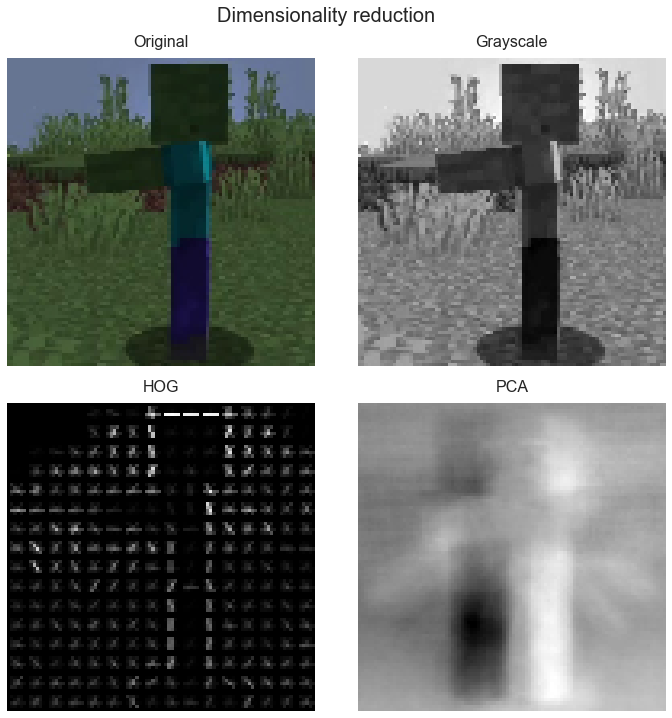

In [518]:
images_sample = [img, gray_img, hog_img, pca_img[5]]
titles = ['Original', 'Grayscale', 'HOG', 'PCA']

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12 / (ncols / nrows)))
fig.subplots_adjust(hspace=0.12, wspace=0.1)
fig.suptitle('Dimensionality reduction', y=0.94)
for i, image in enumerate(images_sample):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col]
    utils.reset_axes(ax)
    ax.set_title(titles[i], pad=12, fontdict={'size': 16})
    ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)

In [16]:
class Resizer(BaseEstimator, TransformerMixin):

    def __init__(self, w: int, h: int):
        self.w = w
        self.h = h

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([cv2.resize(img, (self.w, self.h)) for img in X])


class RGB2GrayTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, w: int, h: int):
        self.w = w
        self.h = h

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = rgb2gray(X.reshape(X.shape[0], self.h, self.w, 3))
        return X.reshape(X.shape[0], -1)


class HogTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        def _hog(img):
            img = img.reshape(TARGET_SIZE, TARGET_SIZE)
            return hog(
                img,
                orientations=self.orientations,
                pixels_per_cell=self.pixels_per_cell,
                cells_per_block=self.cells_per_block,
                block_norm=self.block_norm,
            )

        return np.array([_hog(img) for img in X])


In [533]:
reduce_dim_pipline = Pipeline([
    ('resizer', Resizer(80, 80)),
    ('grayscale', RGB2GrayTransformer(TARGET_SIZE, TARGET_SIZE)),
    ('hog', HogTransformer()),
    ('flatter', Flatter()),
    ('scaler', MinMaxScaler()),
    ('clf', SGDClassifier()),
])

## Бинарная классификация

In [17]:
from itertools import product


def fw_back_edges_sliding(
        w: int,
        h: int,
        left: int = None,
        top: int = None,
        right: int = None,
        bottom: int = None,
) -> List[utils.BBox]:
    bboxes = []

    if left:
        for i in range(h // left):
            bboxes.append([0, i * left, left, left])
            bboxes.append([0, (h - left) - i * left, left, left])

    if top:
        for i in range(w // top):
            bboxes.append([i * top, 0, top, top])
            bboxes.append([(h - top) - i * top, 0, top, top])

    if right:
        for i in range(h // right):
            bboxes.append([w - right, i * right, right, right])
            bboxes.append([w - right, (h - right) - i * right, right, right])

    if bottom:
        for i in range(w // bottom):
            bboxes.append([i * bottom, h - bottom, bottom, bottom])
            bboxes.append([(h - bottom) - i * bottom, h - bottom, bottom, bottom])

    return [utils.BBox(*utils.xywh2xywhn(b, w, h), img_h=h, img_w=w) for b in bboxes]


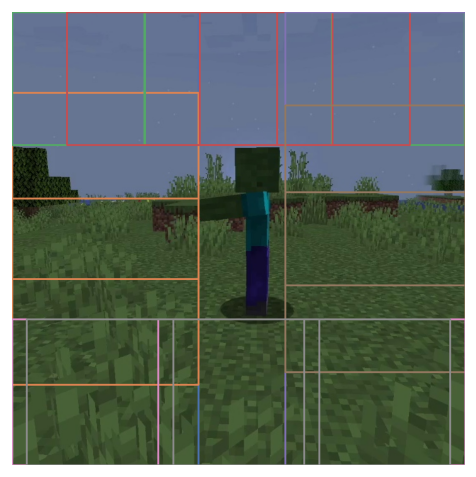

In [12]:
img = utils.Image.open((DATA_IMAGES_ORIG / TIDY_IMAGE_NAMES[0]).with_suffix('.jpg'))
label = utils.Label.open((DATA_LABELS / TIDY_IMAGE_NAMES[0]).with_suffix('.txt'))
ltrb = np.abs(np.array([0, 0, img.w, img.h]) - label.bbox.xyxy(img.w, img.h)).astype(int)
bboxes = fw_back_edges_sliding(img.w, img.h, *ltrb)

tags_sample = ['_'.join(i) for i in product('ltrb', ['fw', 'back'])]
tags = np.array(tags_sample).repeat((np.array([img.h, img.w, img.h, img.w]) // ltrb).repeat(2))
palette = [np.array(i) * 255 for i in sns.color_palette(n_colors=len(bboxes))]

img = img.data
for bbox, tag in zip(bboxes, tags):
    img = utils.visualize_bbox(img, bbox, color=palette[tags_sample.index(tag)])

fig, ax = plt.subplots(figsize=(5, 5))
utils.reset_axes(ax)
ax.imshow(img);

In [22]:
THRESHOLD = 198

dataset['background'] = []
for name in tqdm(TIDY_IMAGE_NAMES):
    img = utils.Image.open((DATA_IMAGES_YOLO / name).with_suffix('.jpg'))
    label = utils.Label.open((DATA_LABELS / name).with_suffix('.txt'))

    ltrb = [
        i if i > THRESHOLD else None
        for i in np.abs(np.array([0, 0, img.w, img.h]) - label.bbox.xyxy(img.w, img.h)).astype(int)
    ]
    bboxes = fw_back_edges_sliding(img.w, img.h, *ltrb)
    for bbox in bboxes:
        new_img = cv2.resize(utils.crop(img.data, bbox), (TARGET_SIZE, TARGET_SIZE))
        dataset['background'].append(new_img)

print(f'background instances: {len(dataset["background"])}\n'
      f'mobs instances: {len(dataset["images"])}')

  0%|          | 0/3772 [00:00<?, ?it/s]

background instances: 3950
mobs instances: 3772


In [27]:
dataset['background'] = RANDOM.choice(
    np.array(dataset['background'], dtype='uint8'),
    size=len(dataset['images']),
    replace=len(dataset["background"]) < len(dataset["images"])
)
print(f'background instances: {len(dataset["background"])}\n'
      f'mobs instances: {len(dataset["images"])}')

background instances: 3772
mobs instances: 3772


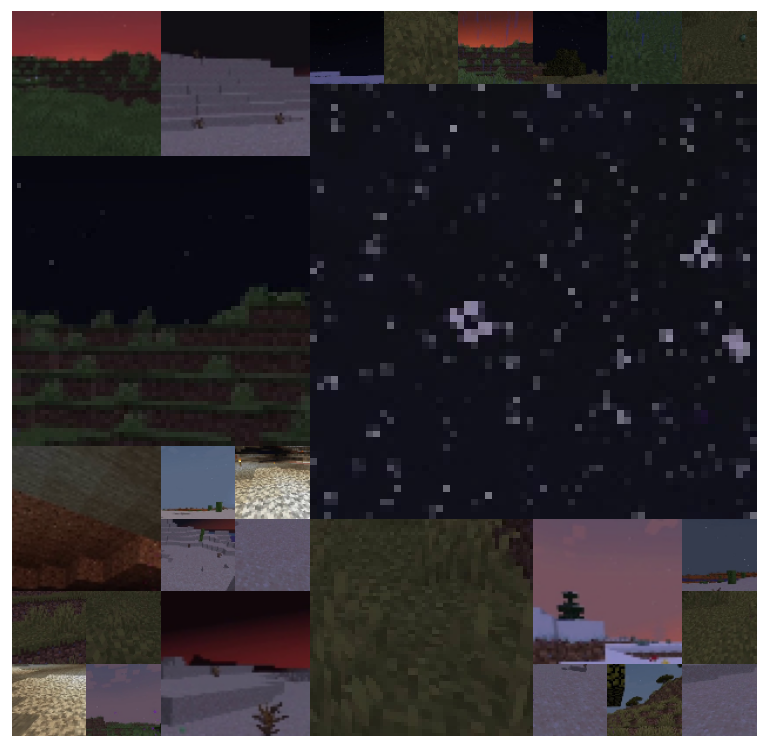

In [39]:
background_27 = RANDOM.choice(dataset['background'], size=27, replace=False)
MOSAIC_27.plot(background_27, fig_width=8)

### Расширение мультиклассовой классификации

In [55]:
mult_pipeline = Pipeline([
    ('flatter', Flatter()),
    ('scaler', MinMaxScaler()),
    ('clf', SGDClassifier(loss='log', random_state=0)),
])
mult_pipeline.fit(X_train, y_train)

Pipeline(steps=[('flatter', Flatter()), ('scaler', MinMaxScaler()),
                ('clf', SGDClassifier(loss='log', random_state=0))])

In [56]:
y_pred = mult_pipeline.predict(background_27)
y_predict_proba = mult_pipeline.predict_proba(background_27)

In [ ]:
y_pred[:7]

In [ ]:
y_predict_proba[:7].round(2)

In [68]:
X = np.vstack([dataset['images'], dataset['background']])
y = np.hstack([np.ones(len(dataset['images'])), np.zeros(len(dataset['background']))])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.8, random_state=0)
X_train.shape

(1508, 64, 64, 3)

In [70]:
bin_pipeline = Pipeline([
    ('flatter', Flatter()),
    ('scaler', MinMaxScaler()),
    ('clf', SGDClassifier(random_state=0)),
])
bin_pipeline.fit(X_train, y_train)

Pipeline(steps=[('flatter', Flatter()), ('scaler', MinMaxScaler()),
                ('clf', SGDClassifier(random_state=0))])

In [71]:
y_pred = bin_pipeline.predict(X_test)
# y_pred_proba = bin_pipeline.predict_proba(X_test)

In [72]:
print(metrics.classification_report(y_test, y_pred, digits=3, target_names=['background', 'mob'], zero_division=0))

              precision    recall  f1-score   support

  background      0.894     0.967     0.930      3012
         mob      0.965     0.886     0.924      3024

    accuracy                          0.927      6036
   macro avg      0.930     0.927     0.927      6036
weighted avg      0.930     0.927     0.927      6036



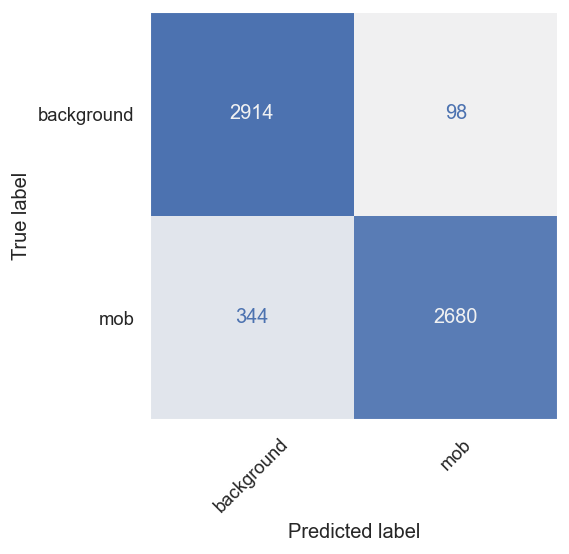

In [73]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=['background', 'mob'],
    colorbar=False,
    xticks_rotation=45,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

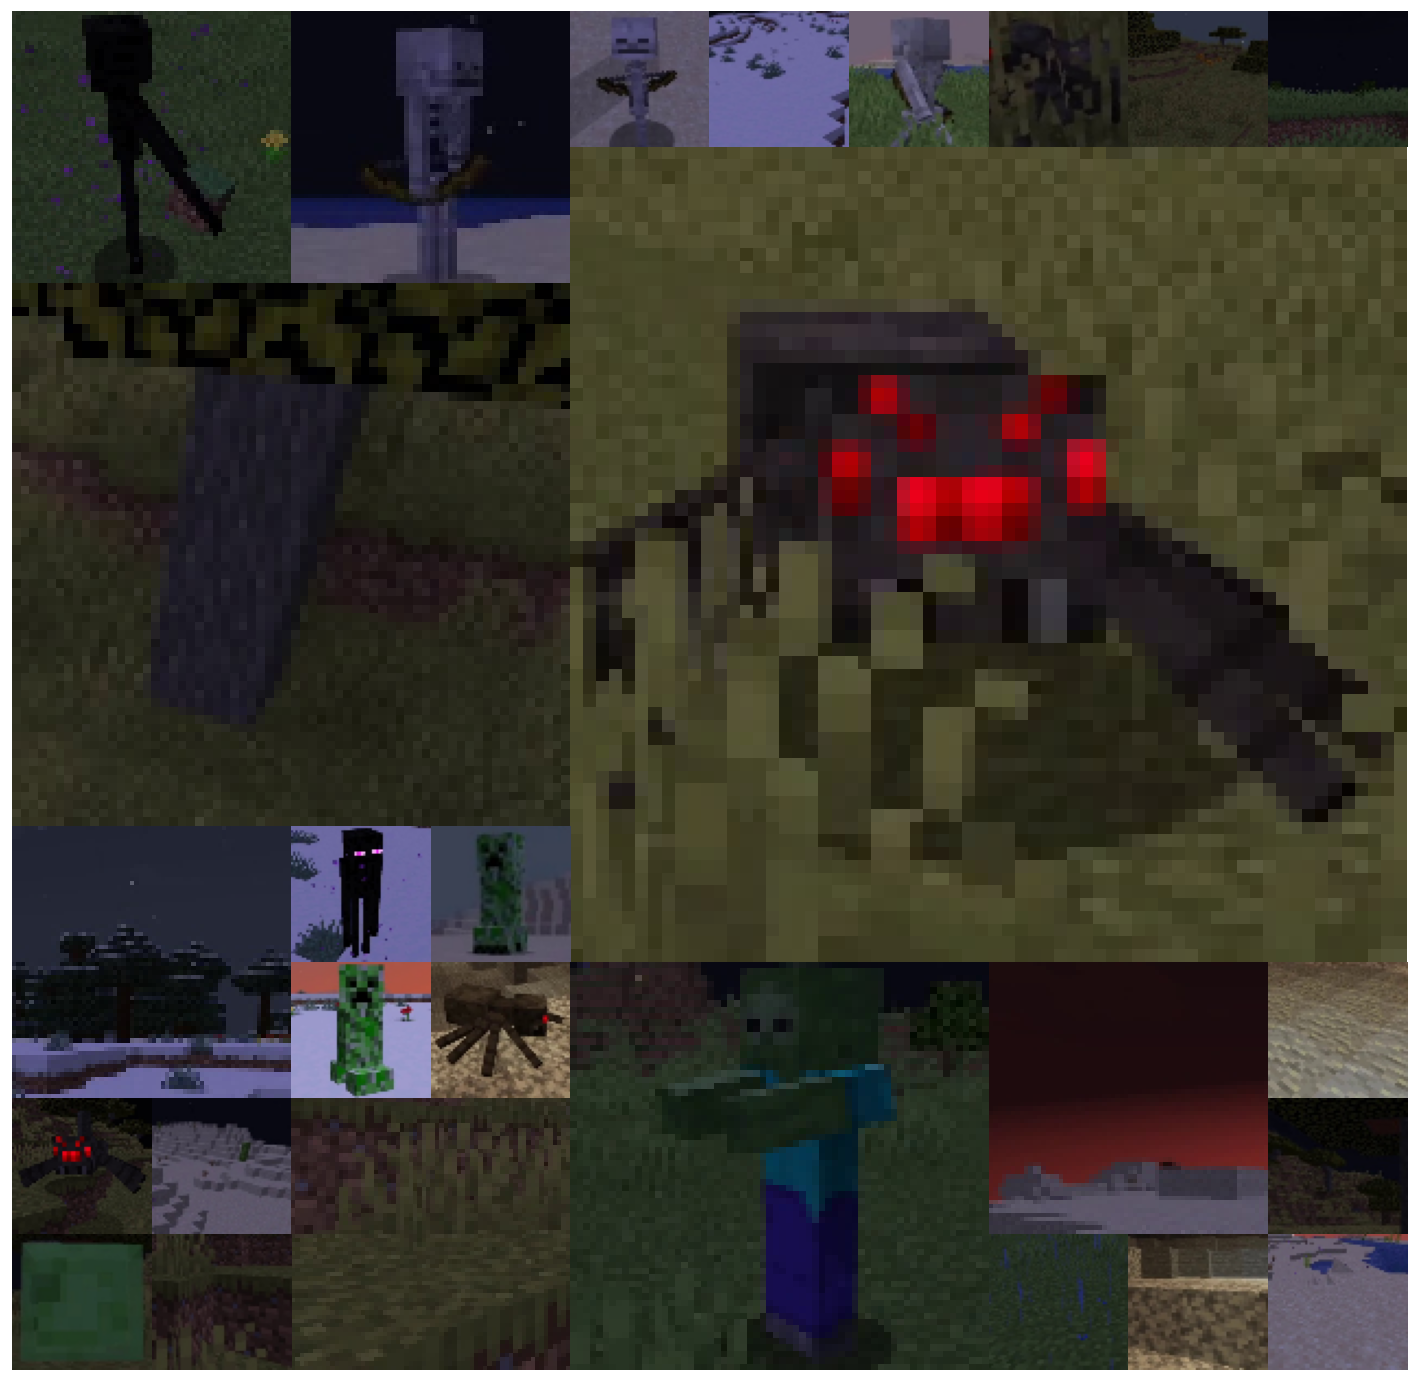

In [30]:
X = dataset['images']
y = dataset['target']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=0)

In [32]:
mult_pipeline = Pipeline([
    ('flatter', Flatter()),
    ('scaler', MinMaxScaler()),
    ('clf', SGDClassifier(random_state=0)),
])
mult_pipeline.fit(X_train, y_train)

Pipeline(steps=[('flatter', Flatter()), ('scaler', MinMaxScaler()),
                ('clf', SGDClassifier(random_state=0))])

In [35]:
y_pred = mult_pipeline.predict(X_test)
# y_pred_proba = mult_pipeline.predict_proba(X_test)

In [36]:
print(metrics.classification_report(y_test, y_pred, digits=3, target_names=MOBS, zero_division=0))

              precision    recall  f1-score   support

      zombie      0.967     1.000     0.983       145
    skeleton      1.000     0.871     0.931       116
      spider      0.968     0.984     0.976       122
     creeper      0.937     0.992     0.963       119
    enderman      1.000     1.000     1.000       122
       slime      0.992     1.000     0.996       131

    accuracy                          0.976       755
   macro avg      0.977     0.974     0.975       755
weighted avg      0.977     0.976     0.976       755



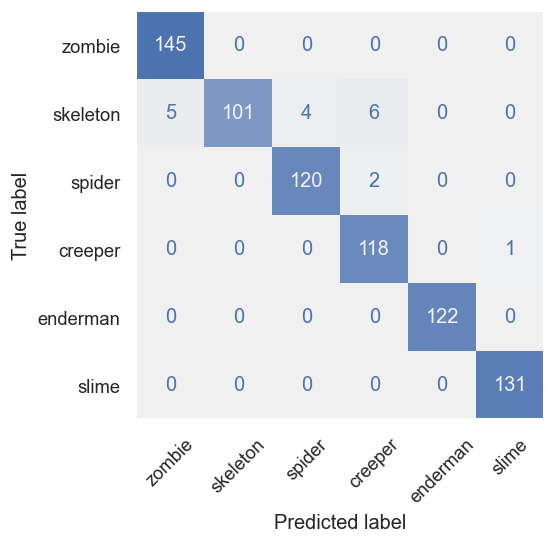

In [37]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=MOBS,
    colorbar=False,
    xticks_rotation=45,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

In [51]:
X = np.vstack([dataset['images'], RANDOM.choice(dataset['background'], size=620)])
y = np.hstack([dataset['target'], np.repeat([6], 620)])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=0)

In [53]:
ext_mult_pipeline = Pipeline([
    ('flatter', Flatter()),
    ('scaler', MinMaxScaler()),
    ('clf', SGDClassifier(random_state=0)),
])
ext_mult_pipeline.fit(X_train, y_train)

Pipeline(steps=[('flatter', Flatter()), ('scaler', MinMaxScaler()),
                ('clf', SGDClassifier(random_state=0))])

In [54]:
y_pred = ext_mult_pipeline.predict(X_test)
# y_pred_proba = mult_pipeline.predict_proba(X_test)

In [57]:
print(metrics.classification_report(y_test, y_pred, digits=3, target_names=[*MOBS, 'background'], zero_division=0))

              precision    recall  f1-score   support

      zombie      0.992     0.992     0.992       126
    skeleton      0.972     0.912     0.941       113
      spider      0.976     0.953     0.964       128
     creeper      1.000     0.993     0.996       138
    enderman      0.951     0.928     0.939       125
       slime      0.992     0.984     0.988       126
  background      0.819     0.919     0.866       123

    accuracy                          0.956       879
   macro avg      0.957     0.954     0.955       879
weighted avg      0.958     0.956     0.956       879



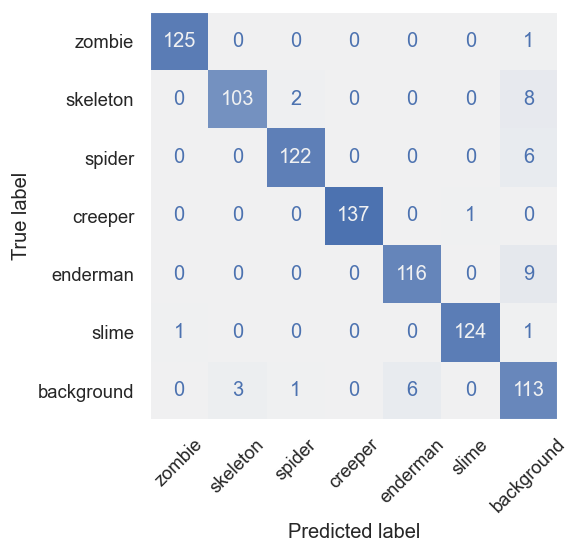

In [58]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=[*MOBS, 'background'],
    colorbar=False,
    xticks_rotation=45,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

# Задача локализации <a name="localization"></a>

In [ ]:
'https://learnopencv.com/training-a-custom-object-detector-with-dlib-making-gesture-controlled-applications/'

In [13]:
def sliding_window(image, window_size, step_size):
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield x, y, image[y: y + window_size[1], x: x + window_size[0]]

In [44]:
int(7 / 3), int(7 / 2)

(2, 3)

In [42]:

from matplotlib.figure import Figure


AttributeError: 'Figure' object has no attribute 'ima'

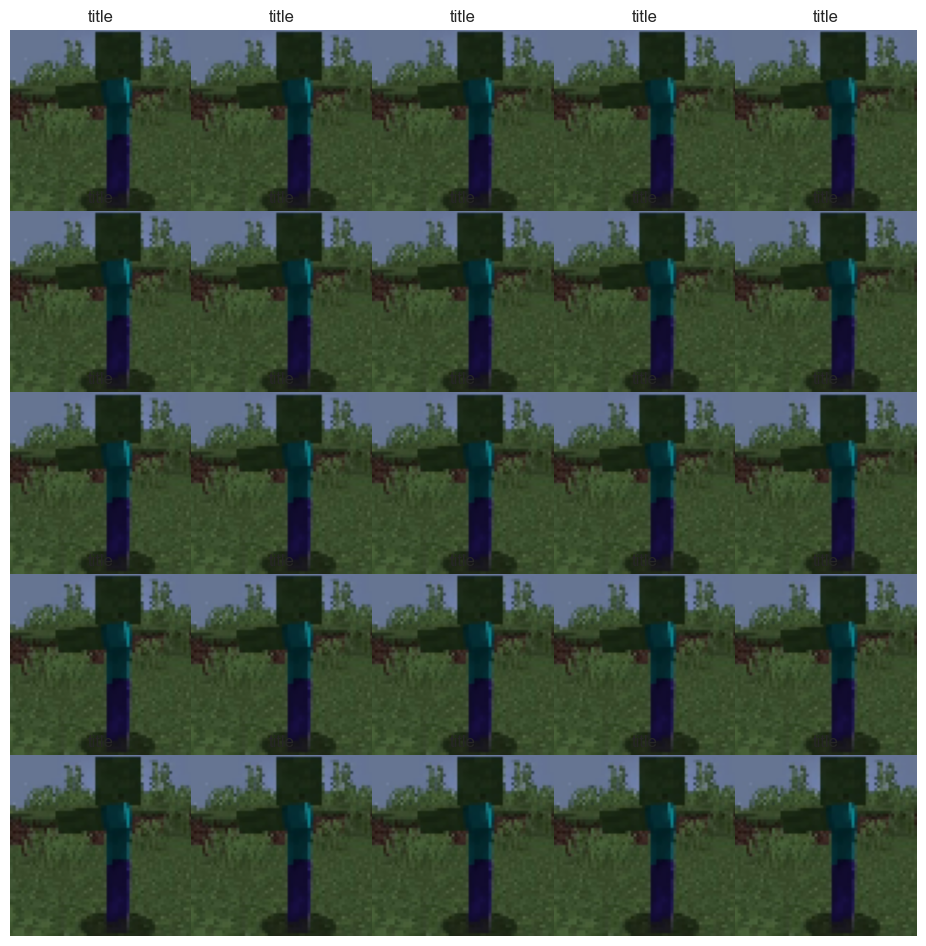

In [70]:
img = dataset['images'][0]

fig: Figure = plt.figure(figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0)
for ax, im in zip(grid, [img] * len(grid)):
    utils.reset_axes(ax)
    ax.set_title('title')
    ax.imshow(im)

fig.savefig('234.png', bbox_inches='tight', pad_inches=1)

# Нейросети. Глубокое обучение <a name="neural-networks"></a>

In [29]:
# colab 1

In [ ]:
# colab 2

In [ ]:
# colab 3